# Product level Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Data for clustering and regression

In [2]:
#Stores Data
Stores = pd.read_csv('KansasStoreDataV1.csv')
#Stores Classification data
StoresClass = pd.read_csv('NonLowPointStoresKansasV1.csv', dtype = str)

In [3]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,102440246,NaN,ON PREMISE,DINING,FAST CASUAL,MEXICAN,UNKNOWN,Y,N,Y,...,0.0625,0.0386,0.0208,0.0248,0.0614,0.0677,0.0667,0.0683,0.0446,0.0307
1,102137482,NaN,ON PREMISE,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,UNKNOWN,N,N,Y,...,0.0620,0.0401,0.0252,0.0262,0.0769,0.0611,0.0572,0.0651,0.0462,0.0367
2,101739463,NaN,ON PREMISE,RECREATION,GOLF/COUNTRY CLUB,OTHER,UNKNOWN,N,N,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,107507929,NaN,ON PREMISE,DINING,CASUAL DINING,ETHNIC,UNKNOWN,N,N,Y,...,0.0324,0.0225,0.0132,0.1070,0.0838,0.0494,0.0310,0.0362,0.0247,0.0199
4,103714966,NaN,ON PREMISE,DINING,CASUAL DINING,ASIAN,UNKNOWN,N,N,Y,...,0.0516,0.0299,0.0134,0.0235,0.0675,0.0774,0.0666,0.0552,0.0355,0.0212


#### Clean Data

In [4]:
#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]
print('Stores after removing stores with no depletion data ',len(Stores))

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] > 0,:] 
print('Stores after removing stores with negative ',len(Stores))

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:]
print('Stores after removing stores with no demographic data ',len(Stores))

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

Stores after removing stores with no depletion data  3098
Stores after removing stores with negative  2789
Stores after removing stores with no demographic data  2584


In [5]:
#Divide stores data into ON PREMISE and OFF PREMISE

StoresON = Stores[Stores.PREMISE_TYPE_DSC == 'ON PREMISE'].reset_index(drop=True)
StoresOFF = Stores[Stores.PREMISE_TYPE_DSC == 'OFF PREMISE'].reset_index(drop=True)

## ON PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [6]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [7]:
len(StoresON.columns)

43

In [8]:
for col in StoresON.columns:
    print(StoresON[col].describe())

count           627
unique          627
top       301967125
freq              1
Name: STORE_CD, dtype: object
count     627.000000
mean       83.964763
std       168.762676
min         0.750000
25%         7.500000
50%        26.000000
75%        99.541050
max      2891.249700
Name: L12M_TY_QTY, dtype: float64
count            627
unique             1
top       ON PREMISE
freq             627
Name: PREMISE_TYPE_DSC, dtype: object
count        627
unique         5
top       DINING
freq         411
Name: CHANNEL_DSC, dtype: object
count               627
unique               17
top       CASUAL DINING
freq                317
Name: SUBCHANNEL_DSC, dtype: object
count       627
unique       11
top       OTHER
freq        170
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                         627
unique                          3
top       TOP 50% ON/ TOP 20% OFF
freq                          327
Name: INDUSTRY_VOL_DSC, dtype: object
count       627
unique        2
top       False
freq  

In [9]:
#Remove Not Necessary Columns
del StoresON['PREMISE_TYPE_DSC'] #Unique
del StoresON['BEER_FLG'] # No Variance
del StoresON['FINE_WINE_FLG'] # No Variance


C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


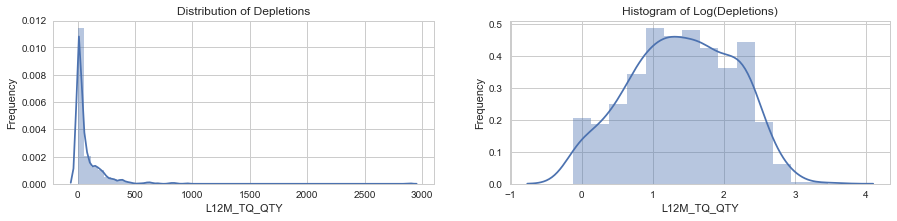

In [11]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresON['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresON['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency');

In [12]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [13]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG',
       'FRANCHISE_FLG', 'WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT',
       'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
       'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [14]:
#Get Dummies
DummiesColumnsON = ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC']
StoresC_ON = binarize(StoresON, DummiesColumnsON)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_ON['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresON['L12M_TY_QTY'].values.reshape(-1,1)) 


In [15]:
# prepare data to fit model
X_labels_ON = [c for c in StoresC_ON.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_ON = StoresC_ON.loc[:,X_labels_ON]

In [16]:
X_ON.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_FOOD_TYPE_GROUP_DSC_OTHER,B_FOOD_TYPE_GROUP_DSC_PIZZA,B_FOOD_TYPE_GROUP_DSC_SEAFOOD,B_FOOD_TYPE_GROUP_DSC_SMALL FOOD,B_FOOD_TYPE_GROUP_DSC_STEAK,B_FOOD_TYPE_GROUP_DSC_VARIED MENU,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,False,False,0.9009,0.0147,0.0065,0.0529,0.0100,0.0125,...,1,0,0,0,0,0,1,0,0,0.001124
1,False,False,True,True,0.7495,0.0968,0.0631,0.0668,0.0133,0.0179,...,0,0,0,0,0,1,0,0,1,0.012368
2,False,False,False,False,0.8433,0.0436,0.0080,0.0510,0.0101,0.0161,...,1,0,0,0,0,0,0,0,1,0.001470
3,False,False,True,True,0.9453,0.0098,0.0035,0.0202,0.0043,0.0064,...,1,0,0,0,0,0,0,1,0,0.000432
4,True,False,True,True,0.7901,0.0996,0.0231,0.0655,0.0116,0.0200,...,0,0,0,0,0,0,0,0,1,0.040554


### Clustering

#### Choose number of Clusters

In [17]:
#Tunned Elbow Method ON
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs= -2)
    kmeans.fit(X_ON)
    meandistortions.append(sum(np.min(cdist(X_ON, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_ON.shape[0])

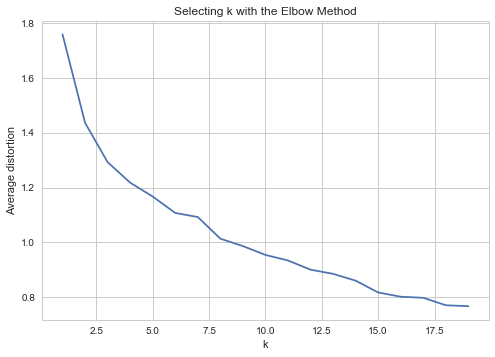

In [18]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [19]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_ON)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_ON, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.306309
1,3,0.279501
2,4,0.282943
3,5,0.255370
4,6,0.257262
5,7,0.264969
6,8,0.256073
7,9,0.289801
8,10,0.303195
9,11,0.289574


In [20]:
#Cluster the Data ON
kmeans_model = cluster.KMeans(n_clusters=4, random_state=1, n_jobs = -2).fit(X_ON)
labels = kmeans_model.labels_

In [21]:
#Assign Cluster to Data
StoresON['CLUSTER'] = labels

In [22]:
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,101914477,4.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,...,0.0415,0.0285,0.0251,0.0676,0.0624,0.0578,0.0648,0.0460,0.0433,1
1,103707016,36.500,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0405,0.0228,0.0268,0.0641,0.0622,0.0644,0.0676,0.0435,0.0318,1
2,101930302,5.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,False,False,...,0.0519,0.0328,0.0224,0.0561,0.0551,0.0613,0.0715,0.0577,0.0472,1
3,101943225,2.000,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0435,0.0283,0.0223,0.0527,0.0614,0.0694,0.0696,0.0473,0.0435,1
4,107487797,117.972,BAR/NIGHTCLUB,SPORTS BAR,AMERICAN,TOP 50% ON/ TOP 20% OFF,True,False,True,True,...,0.0414,0.0207,0.0230,0.0575,0.0688,0.0657,0.0663,0.0462,0.0314,1


### Load Store Data

In [23]:
#load the All stores in Kansas
All_Stores_Kansas = pd.read_csv('AllStoresKansas.csv')
All_Stores_Kansas = All_Stores_Kansas.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Kansas.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.750
1,101537249,CORONA EX 3.2 24OZ BT,OFF,32.000
2,107443744,PACIFICO 6PK BT,OFF,10.000
3,200572989,CORONA EX 3.2 6PK BT,OFF,22.000
4,101476216,CORONITA 7OZ 6PK BT,OFF,153.418


In [24]:
#clean data

#remove NA Depletion 
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Kansas.shape

(33000, 4)

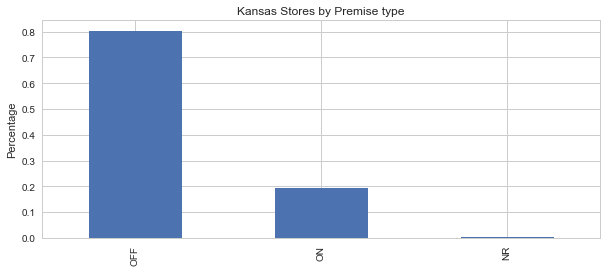

In [25]:
# Kansas Stores by Premise type
premise_type = All_Stores_Kansas.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Kansas Stores by Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [26]:
LowPointOn = pd.read_csv('KansasLowPointOnProducts.csv')
Top5LowPointOn = LowPointOn.head(7)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0       CORONA EX 3.2 6PK BT
1      CORONA EX 3.2 12PK BT
2          CORONA LT 18PK BT
3      MODELO ESP 3.2 6PK BT
4     MODELO ESP 3.2 12PK BT
5    CORONA LIGHT 1/2 BL KEG
6    MODELO ESP 3.2 12PK CAN
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [27]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[0,1,3,4,6]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT', 'MODELO ESP 12PK CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
1,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
2,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
3,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT
4,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN


In [28]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT',
 'MODELO ESP 12PK CAN']

### Analysis for On-Premise

In [29]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,101733532,MODELO ESP 12PK BT,ON,14.0
1,301616936,MODELO ESP 6PK BT,ON,16.0
2,101733587,CORONA EX 12PK BT,ON,7.0
3,103639684,CORONA EX 12PK BT,ON,3.0
4,201725170,MODELO ESP 6PK BT,ON,17.0


In [30]:
len(Top5_On_pairs_stores)

2466

In [31]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 12PK BT', 'MODELO ESP 6PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK BT', 'CORONA EX 3.2 12PK BT',
       'MODELO ESP 3.2 6PK BT', 'CORONA EX 3.2 6PK BT', 'CORONA EX 6PK BT',
       'MODELO ESP 3.2 12PK CAN', 'MODELO ESP 12PK CAN'], dtype=object)

In [32]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] == graph_DF['Product']        

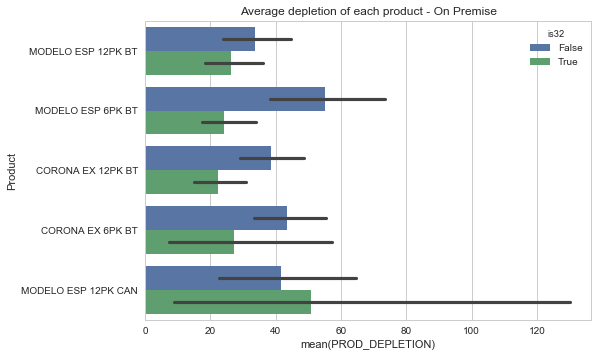

In [33]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product - On Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

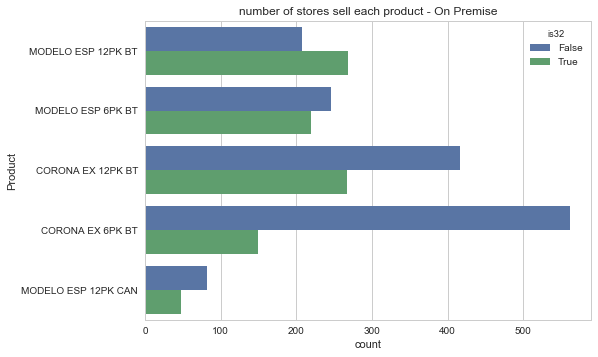

In [34]:
#plot number of stores sell each product for On-premise
plt.title("number of stores sell each product - On Premise")
#sns.barplot(x=graph_DF['Product'].value_counts(),y= graph_DF['Product'], hue=graph_DF["is32"]);
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

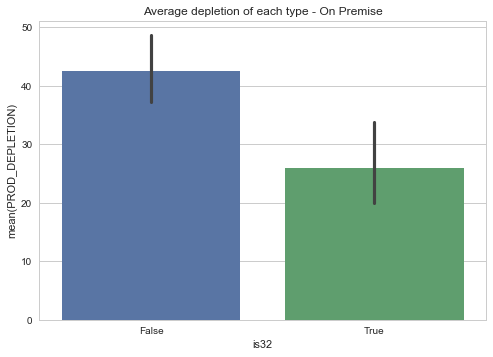

In [35]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


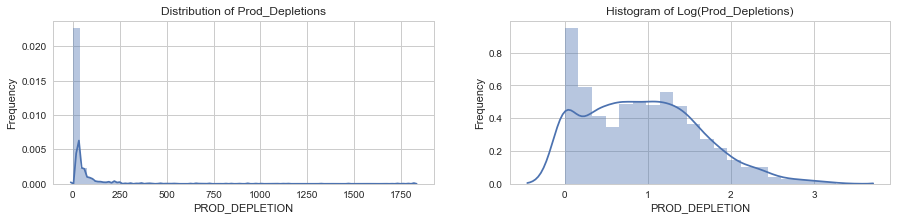

In [36]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

### Merge Regression Data and Product Data

In [40]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataON = pd.merge(StoresON, Top5_On_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,101914477,4.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,...,0.0648,0.0460,0.0433,1,101914477,CORONA EX 3.2 6PK BT,ON,17.0,CORONA EX 6PK BT,False
1,103707016,36.5,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,VARIED MENU,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0676,0.0435,0.0318,1,103707016,CORONA EX 6PK BT,ON,3.0,CORONA EX 6PK BT,True
2,101930302,5.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,False,False,...,0.0715,0.0577,0.0472,1,101930302,CORONA EX 3.2 12PK BT,ON,16.0,CORONA EX 12PK BT,False
3,101930302,5.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,False,False,...,0.0715,0.0577,0.0472,1,101930302,CORONA EX 3.2 6PK BT,ON,13.0,CORONA EX 6PK BT,False
4,101943225,2.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0696,0.0473,0.0435,1,101943225,MODELO ESP 3.2 12PK BT,ON,1.0,MODELO ESP 12PK BT,False


In [41]:
len(RegressionDataON)

1418

In [42]:
#pair1: CORONA EX 3.2 6PK BT vs CORONA EX 6PK BT
subset1 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_ON_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_ON_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.195
Model:                                OLS   Adj. R-squared:                  0.185
Method:                     Least Squares   F-statistic:                     20.81
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           2.23e-15
Time:                            20:47:47   Log-Likelihood:                -620.33
No. Observations:                     349   AIC:                             1251.
Df Residuals:                         344   BIC:                             1270.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------

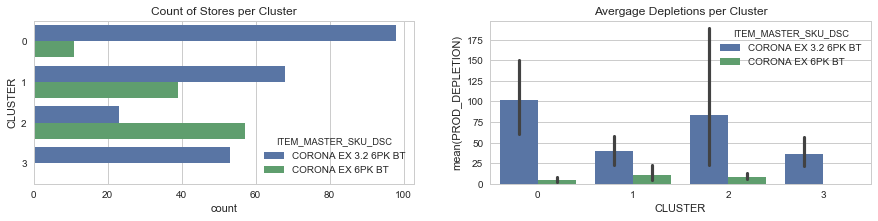

In [45]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

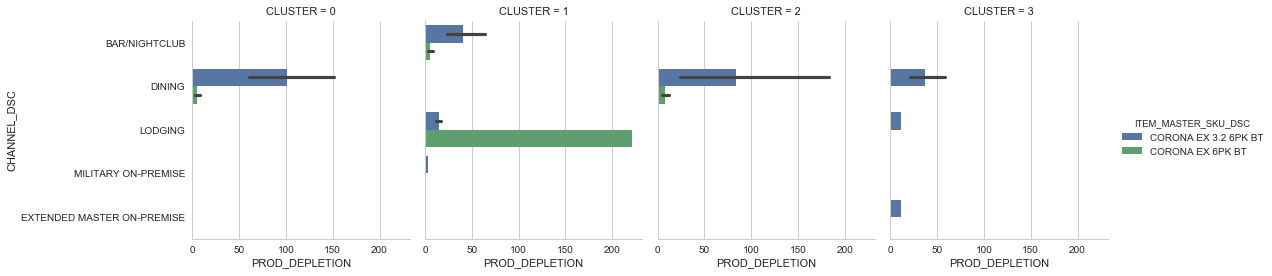

In [46]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [47]:
#pair 2: CORONA EX 12PK BT vs CORONA EX 3.2 12PK BT
subset2 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_ON_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset2)
print(Regression_ON_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.021
Model:                                OLS   Adj. R-squared:                  0.011
Method:                     Least Squares   F-statistic:                     2.180
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):             0.0705
Time:                            20:53:45   Log-Likelihood:                -740.79
No. Observations:                     410   AIC:                             1492.
Df Residuals:                         405   BIC:                             1512.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

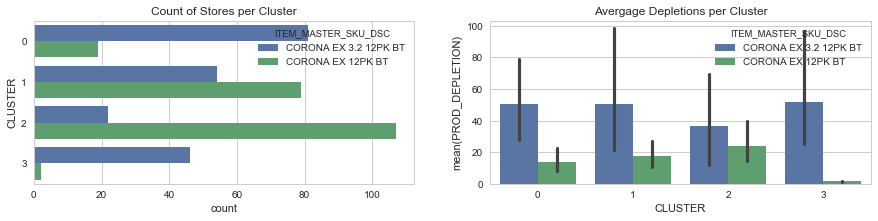

In [48]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

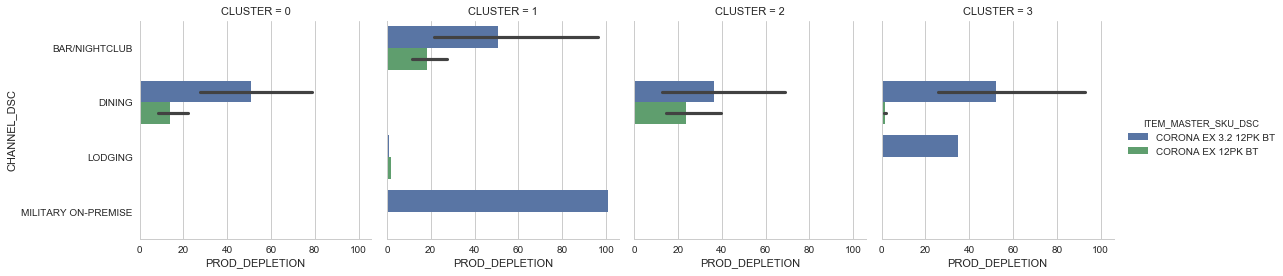

In [49]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [50]:
#pair 3: MODELO ESP 3.2 6PK BT vs MODELO ESP 6PK BT
subset3 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_ON_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset3)
print(Regression_ON_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.038
Model:                                OLS   Adj. R-squared:                  0.023
Method:                     Least Squares   F-statistic:                     2.626
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):             0.0351
Time:                            20:54:41   Log-Likelihood:                -495.20
No. Observations:                     272   AIC:                             1000.
Df Residuals:                         267   BIC:                             1018.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

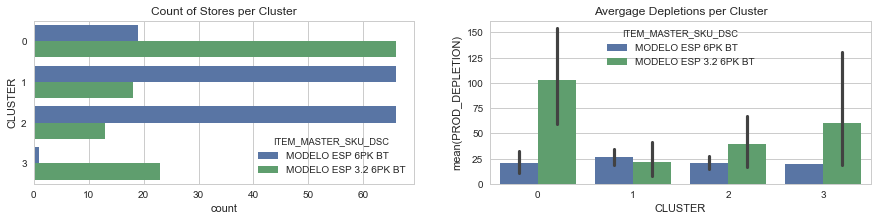

In [51]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

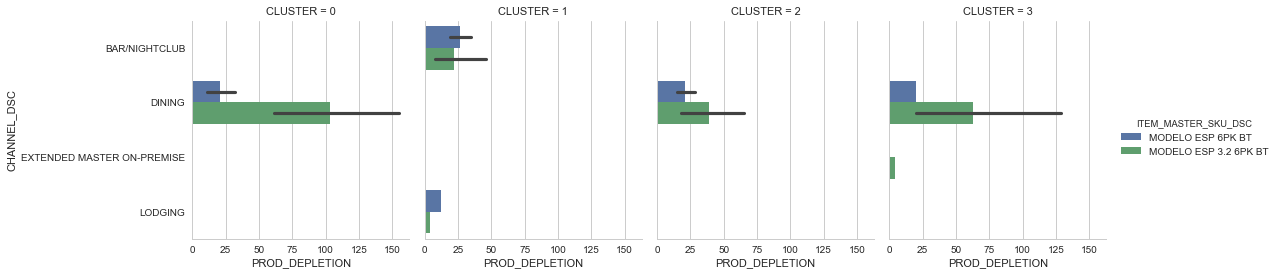

In [52]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [53]:
#pair 4  MODELO ESP 12PK BT vs  MODELO ESP 3.2 12PK BT
subset4 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_ON_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset4)
print(Regression_ON_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.010
Model:                                OLS   Adj. R-squared:                 -0.003
Method:                     Least Squares   F-statistic:                    0.7700
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):              0.545
Time:                            20:56:46   Log-Likelihood:                -595.51
No. Observations:                     317   AIC:                             1201.
Df Residuals:                         312   BIC:                             1220.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------

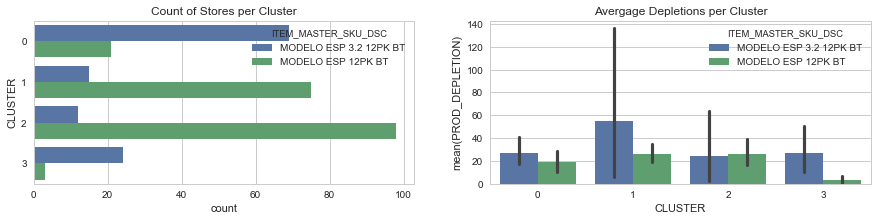

In [54]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

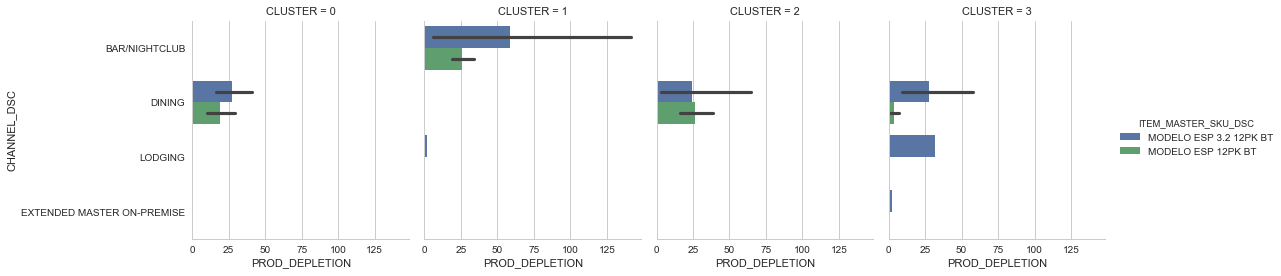

In [55]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [56]:
#pair 5  MODELO ESP 12PK CAN vs MODELO ESP 3.2 12PK CAN
subset5 = RegressionDataON.loc[RegressionDataON['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_ON_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(CLUSTER)', data= subset5)
print(Regression_ON_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                 -0.049
Method:                     Least Squares   F-statistic:                    0.1928
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):              0.941
Time:                            20:57:49   Log-Likelihood:                -134.20
No. Observations:                      70   AIC:                             278.4
Df Residuals:                          65   BIC:                             289.6
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

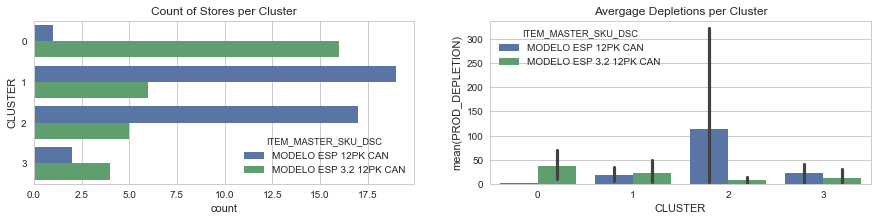

In [57]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

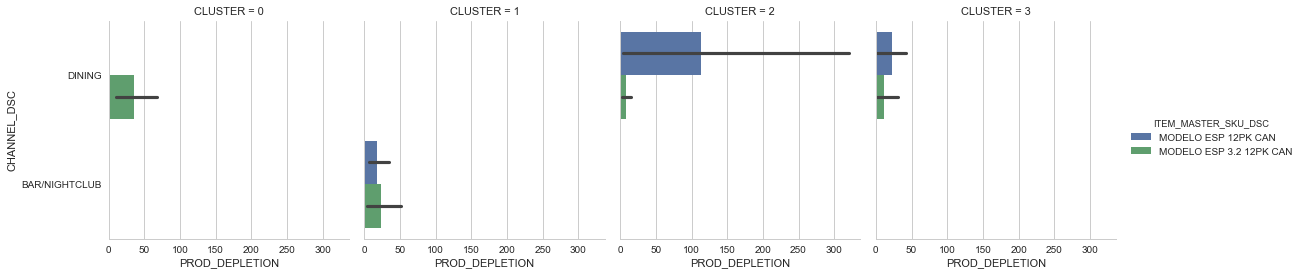

In [58]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");

## OFF PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [59]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [60]:
len(StoresOFF.columns)

43

In [61]:
for col in StoresOFF.columns:
    print(StoresOFF[col].describe())

count          1957
unique         1957
top       101404021
freq              1
Name: STORE_CD, dtype: object
count     1957.000000
mean       588.284411
std       1503.672089
min          1.000000
25%         23.000000
50%        124.000000
75%        515.250000
max      29712.999500
Name: L12M_TY_QTY, dtype: float64
count            1957
unique              1
top       OFF PREMISE
freq             1957
Name: PREMISE_TYPE_DSC, dtype: object
count                  1957
unique                    8
top       CONVENIENCE STORE
freq                    832
Name: CHANNEL_DSC, dtype: object
count                         1957
unique                          18
top       CONVENTIONAL CONVENIENCE
freq                           829
Name: SUBCHANNEL_DSC, dtype: object
count      1957
unique        1
top       OTHER
freq       1957
Name: FOOD_TYPE_GROUP_DSC, dtype: object
count                              1957
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq    

In [62]:
#Remove Not Necessary Columns
del StoresOFF['PREMISE_TYPE_DSC'] #Unique
del StoresOFF['FOOD_TYPE_GROUP_DSC'] #Unique
del StoresOFF['BEER_FLG'] # No Variance
del StoresOFF['FINE_WINE_FLG'] # No Variance


C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


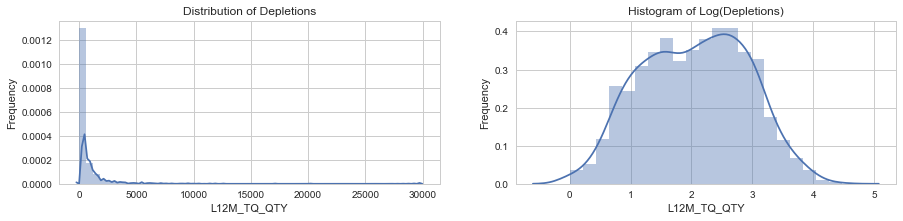

In [63]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresOFF['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresOFF['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [64]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'WINE_FLG',
       'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [65]:
#Get Dummies
DummiesColumnsOFF = ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC']
StoresC_OFF = binarize(StoresOFF, DummiesColumnsOFF)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_OFF['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresOFF['L12M_TY_QTY'].values.reshape(-1,1)) 


In [66]:
# prepare data to fit model
X_labels_OFF = [c for c in StoresC_OFF.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_OFF = StoresC_OFF.loc[:,X_labels_OFF]

In [67]:
X_OFF.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_SUBCHANNEL_DSC_SUPERCENTER,B_SUBCHANNEL_DSC_SUPERETTE,B_SUBCHANNEL_DSC_SUPERMARKET-CONVENTIONAL,B_SUBCHANNEL_DSC_SUPERMARKET-LIMITED ASSORTMENT,B_SUBCHANNEL_DSC_SUPERMARKET-NATURAL/GOURMET FOODS,B_SUBCHANNEL_DSC_WINE SPECIALTY STORE,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,True,True,0.9437,0.0103,0.0081,0.0195,0.0041,0.0061,...,0,0,0,0,0,0,0,0,1,0.002474
1,False,False,True,True,0.8233,0.0051,0.0065,0.1577,0.0274,0.0505,...,0,0,0,0,0,0,0,0,1,0.010442
2,False,False,True,True,0.7785,0.0523,0.0719,0.0742,0.0117,0.0222,...,0,0,0,0,0,0,0,0,1,0.020657
3,True,False,False,False,0.6504,0.1406,0.0332,0.1328,0.0238,0.0385,...,0,0,0,0,0,0,1,0,0,0.001346
4,False,False,True,True,0.9537,0.0015,0.0010,0.0150,0.0029,0.0039,...,0,0,0,0,0,0,0,0,1,0.004182


### Clustering

#### Choose number of Clusters

In [68]:
#Tunned Elbow Method OFF
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs= -2)
    kmeans.fit(X_OFF)
    meandistortions.append(sum(np.min(cdist(X_OFF, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_OFF.shape[0])

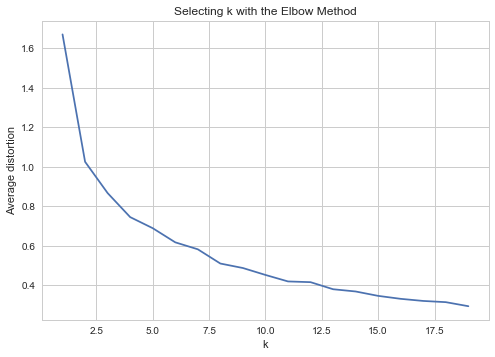

In [69]:
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [70]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_OFF)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_OFF, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.519901
1,3,0.533786
2,4,0.520731
3,5,0.552142
4,6,0.531447
5,7,0.542286
6,8,0.546306
7,9,0.566513
8,10,0.592733
9,11,0.610873


In [71]:
#Cluster the Data OFF
kmeans_model = cluster.KMeans(n_clusters=5, random_state=1, n_jobs = -2).fit(X_OFF)
labels = kmeans_model.labels_

In [72]:
#Assign Cluster to Data
StoresOFF['CLUSTER'] = labels

In [73]:
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,107027552,74.5000,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0527,0.0431,0.0231,0.0486,0.0518,0.0589,0.0753,0.0581,0.0576,1
1,201650423,311.2502,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.8233,...,0.0475,0.0307,0.0202,0.0463,0.0540,0.0624,0.0649,0.0459,0.0381,1
2,100766228,614.7500,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.7785,...,0.0339,0.0198,0.0638,0.0854,0.0565,0.0429,0.0522,0.0372,0.0258,1
3,100558459,41.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,True,False,False,False,0.6504,...,0.0252,0.0169,0.0491,0.0823,0.0514,0.0386,0.0413,0.0278,0.0231,3
4,101633764,125.2500,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9537,...,0.0633,0.0424,0.0199,0.0536,0.0463,0.0577,0.0840,0.0638,0.0577,1


### Load Product Data for Off-Premise

In [75]:
#get top 5 beers for off- premise
LowPointOff = pd.read_csv('KansasLowPointOffProducts.csv')
Top5LowPointOff = LowPointOff.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0      CORONA EX 3.2 12PK BT
1          CORONA LT 12PK BT
2       CORONA EX 3.2 6PK BT
3    MODELO ESP 3.2 12PK CAN
4           CORONA LT 6PK BT
5           VICTORIA 12PK BT
6          CORONA LT 18PK BT
7      CORONA EX 3.2 18PK BT
8      MODELO ESP 3.2 6PK BT
9    MODELO CHELADA 24OZ CAN
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [76]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[0,2,3,7,8]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'CORONA EX 6PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 18PK BT', 'MODELO ESP 6PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
2,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
3,CORONA EX 3.2 18PK BT,CORONA EX 18PK BT
4,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT


In [77]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 18PK BT',
 'MODELO ESP 3.2 6PK BT',
 'CORONA EX 12PK BT',
 'CORONA EX 6PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 18PK BT',
 'MODELO ESP 6PK BT']

### Analysis for Off-Premise

In [78]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103946193,CORONA EX 18PK BT,OFF,84.75
1,200572989,CORONA EX 3.2 6PK BT,OFF,22.00
2,107354744,CORONA EX 18PK BT,OFF,353.25
3,101967580,CORONA EX 3.2 6PK BT,OFF,197.00
4,100091971,MODELO ESP 3.2 6PK BT,OFF,63.00


In [80]:
len(Top5_Off_pairs_stores)

8285

In [81]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 18PK BT', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 3.2 6PK BT', 'CORONA EX 3.2 12PK BT',
       'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK CAN',
       'CORONA EX 6PK BT', 'MODELO ESP 3.2 12PK CAN',
       'CORONA EX 3.2 18PK BT'], dtype=object)

In [82]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] == graph_DF['Product']  

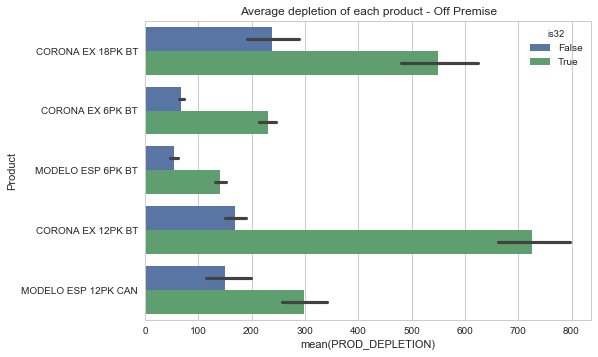

In [83]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

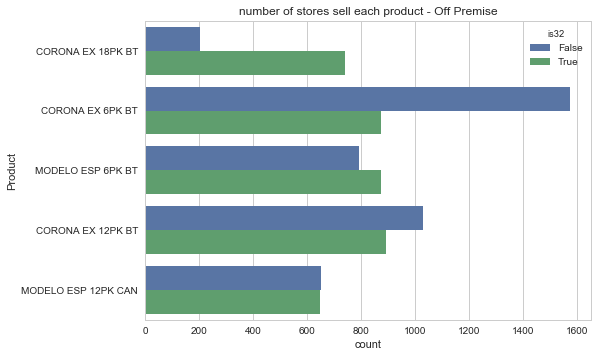

In [84]:
#plot number of stores sell each product for Off-premise
plt.title("number of stores sell each product - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

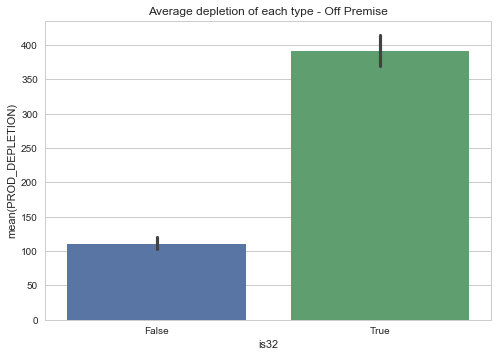

In [85]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

C:\Users\qifan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


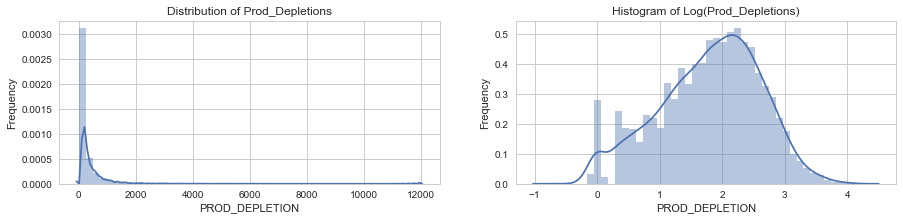

In [86]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

### Regression Analysis on Five products for Off-premise

### Merge Regression Data and Product Data

In [88]:
#Inner join StoreON Data with Top5_On_pairs_stores for regression
RegressionDataOFF = pd.merge(StoresOFF, Top5_Off_pairs_stores, left_on='STORE_CD', right_on="RTL_STORE_CD", how="inner")
RegressionDataOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,107027552,74.5,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0753,0.0581,0.0576,1,107027552,MODELO ESP 12PK CAN,OFF,2.0,MODELO ESP 12PK CAN,True
1,107027552,74.5,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0753,0.0581,0.0576,1,107027552,CORONA EX 6PK BT,OFF,51.0,CORONA EX 6PK BT,True
2,107027552,74.5,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0753,0.0581,0.0576,1,107027552,CORONA EX 12PK BT,OFF,123.0,CORONA EX 12PK BT,True
3,107027552,74.5,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0753,0.0581,0.0576,1,107027552,CORONA EX 18PK BT,OFF,6.0,CORONA EX 18PK BT,True
4,107027552,74.5,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9437,...,0.0753,0.0581,0.0576,1,107027552,MODELO ESP 6PK BT,OFF,9.0,MODELO ESP 6PK BT,True


In [89]:
len(RegressionDataOFF)

6626

### Regression controlling for Cluster

In [90]:
#pair1: 'CORONA EX 3.2 12PK BT', 'CORONA EX 12PK BT'
subset1 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)
Regression_Off_pair1_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset1)
print(Regression_Off_pair1_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.332
Model:                                OLS   Adj. R-squared:                  0.330
Method:                     Least Squares   F-statistic:                     150.6
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):          5.21e-130
Time:                            21:20:59   Log-Likelihood:                -2782.4
No. Observations:                    1522   AIC:                             5577.
Df Residuals:                        1516   BIC:                             5609.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

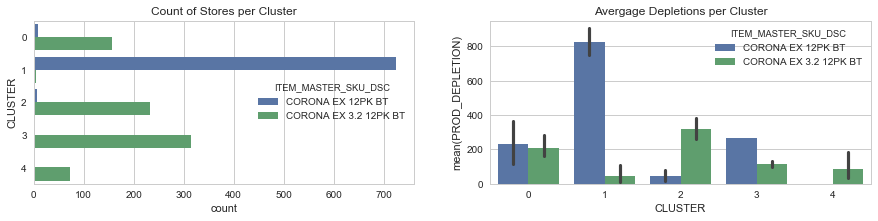

In [91]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset1);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset1);

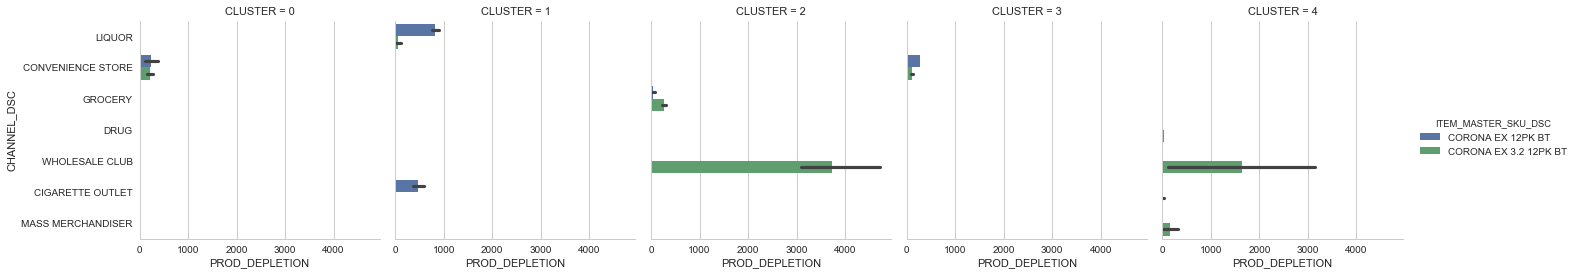

In [92]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset1, kind="bar");

In [93]:
#pair2: 'CORONA EX 3.2 6PK BT', 'CORONA EX 6PK BT'
subset2 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)
Regression_Off_pair2_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset2)
print(Regression_Off_pair2_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.242
Model:                                OLS   Adj. R-squared:                  0.240
Method:                     Least Squares   F-statistic:                     118.9
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):          2.11e-109
Time:                            21:24:03   Log-Likelihood:                -3051.0
No. Observations:                    1871   AIC:                             6114.
Df Residuals:                        1865   BIC:                             6147.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------

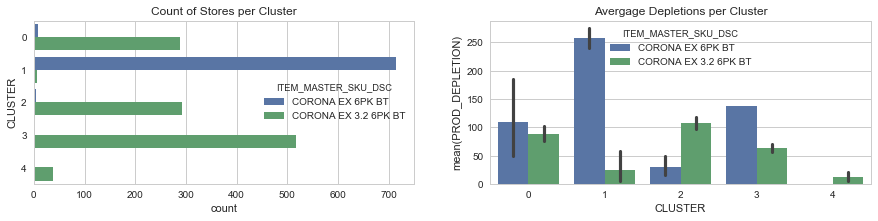

In [94]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset2);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset2);

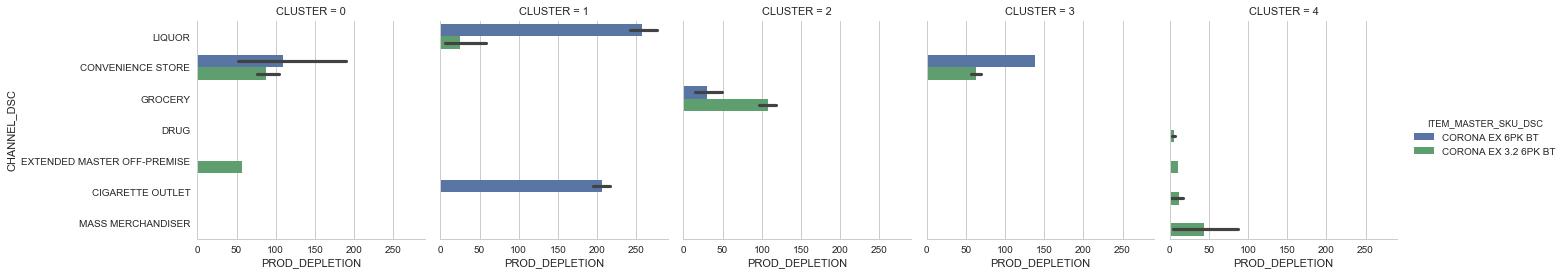

In [95]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset2, kind="bar");

In [96]:
#pair3: 'MODELO ESP 3.2 12PK CAN', 'MODELO ESP 12PK CAN'
subset3 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)
Regression_Off_pair3_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset3)
print(Regression_Off_pair3_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.058
Model:                                OLS   Adj. R-squared:                  0.054
Method:                     Least Squares   F-statistic:                     13.08
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           2.21e-12
Time:                            21:26:48   Log-Likelihood:                -2225.5
No. Observations:                    1069   AIC:                             4463.
Df Residuals:                        1063   BIC:                             4493.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

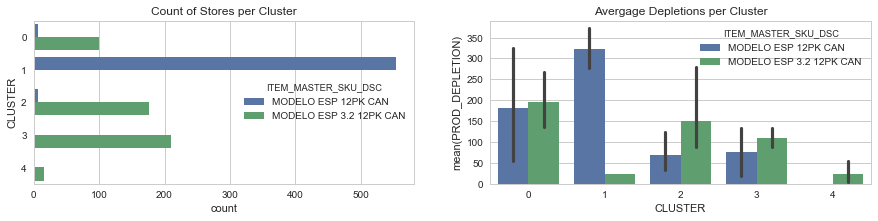

In [97]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset3);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset3);

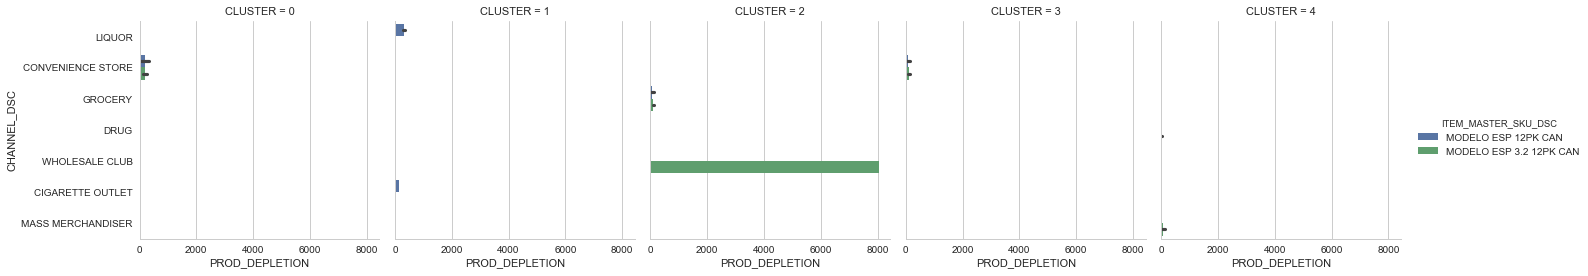

In [98]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset3, kind="bar");

In [99]:
#pair4: 'CORONA EX 3.2 18PK BT', 'CORONA EX 18PK BT'
subset4 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)
Regression_Off_pair4_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset4)
print(Regression_Off_pair4_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.051
Model:                                OLS   Adj. R-squared:                  0.045
Method:                     Least Squares   F-statistic:                     8.573
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           6.39e-08
Time:                            21:28:34   Log-Likelihood:                -1691.3
No. Observations:                     801   AIC:                             3395.
Df Residuals:                         795   BIC:                             3423.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------

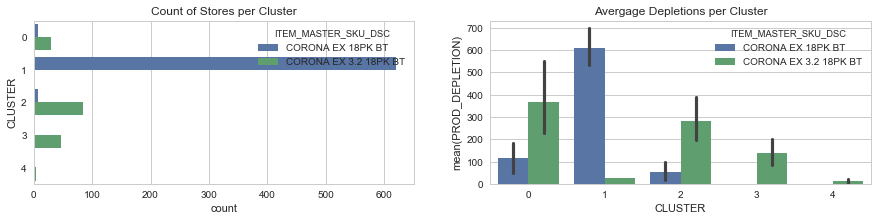

In [100]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset4);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset4);

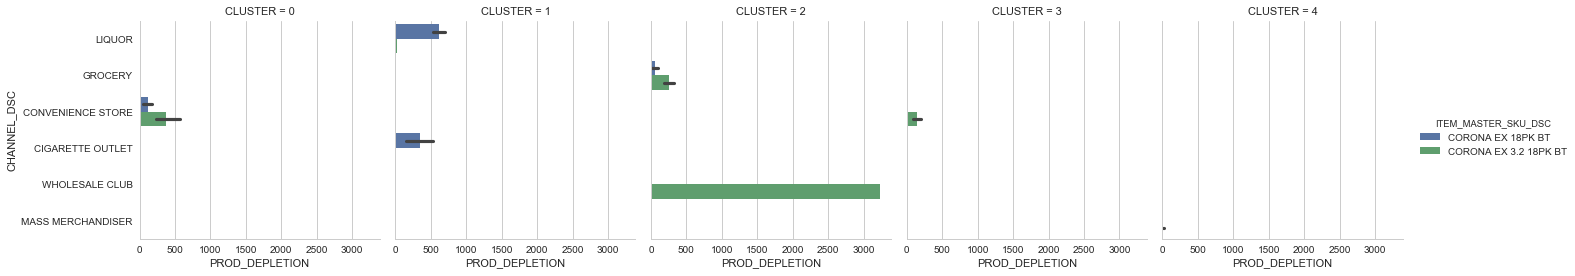

In [101]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset4, kind="bar");

In [102]:
#pair5: 'MODELO ESP 6PK BT', 'MODELO ESP 3.2 6PK BT'
subset5 = RegressionDataOFF.loc[RegressionDataOFF['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)
Regression_Off_pair5_cluster = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(CLUSTER)', data= subset5)
print(Regression_Off_pair5_cluster.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.204
Model:                                OLS   Adj. R-squared:                  0.201
Method:                     Least Squares   F-statistic:                     69.67
Date:                    Wed, 05 Jul 2017   Prob (F-statistic):           5.79e-65
Time:                            21:29:28   Log-Likelihood:                -2479.1
No. Observations:                    1363   AIC:                             4970.
Df Residuals:                        1357   BIC:                             5002.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

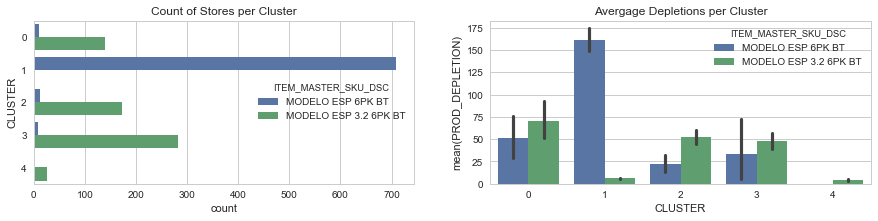

In [103]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "ITEM_MASTER_SKU_DSC", data=subset5);

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="PROD_DEPLETION", hue="ITEM_MASTER_SKU_DSC", data=subset5);

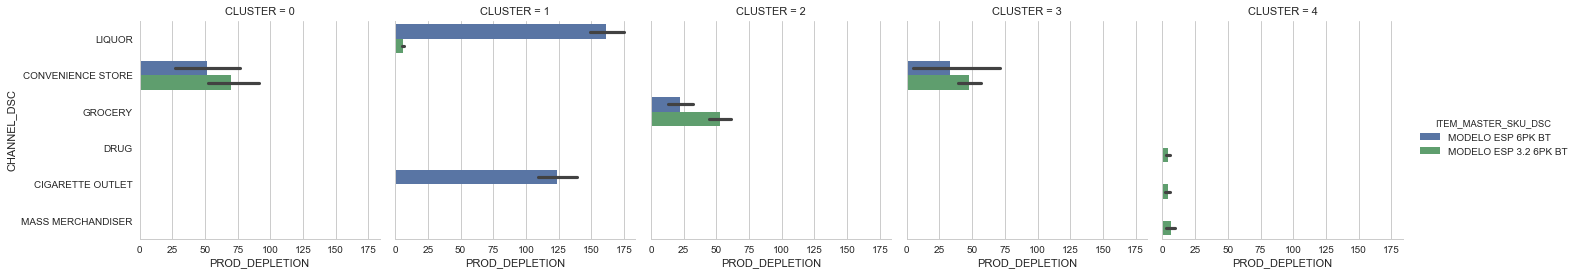

In [104]:
sns.factorplot(x='PROD_DEPLETION' ,y="CHANNEL_DSC", hue="ITEM_MASTER_SKU_DSC",
               col="CLUSTER", data=subset5, kind="bar");